# Maximum likelihood estimation

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

In [2]:
import numpy as np
from scipy.stats import norm, multivariate_normal, binom # Gausisan PDFs
from numpy.random import randn, rand, randint # random number generators

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%autosave 0

Autosave disabled


In [3]:
matplotlib.rcParams.update({'font.size': 17})

- Consider the Binomial distribution: you have a coin with probability $w$ of heads.
- Classical probability is about _generating data from the parameters_: that is, tell me $w$ and I'll generate data from you. E.g.

In [4]:
w = 0.25 
n = 100
heads = np.random.binomial(n, w)
heads

23

In [5]:
np.random.binomial(n, w, size=20) # a bigger sample

array([20, 30, 21, 23, 28, 23, 25, 22, 23, 27, 22, 23, 21, 25, 20, 24, 26,
       29, 28, 25])

In [6]:
np.random.randn(10) # a sample of size 10 from the Gaussian distribution

array([-0.23107738,  0.20647248, -0.18021665,  0.45485467, -0.26950183,
        1.05098665, -0.86939697, -1.95049604,  0.62039537,  1.86897661])

- Now imagine we're going the other direction, which is what typically happens in ML:
  - You assume the distribution is binomial but you don't know $w$
  - You flip the coin 100 times and observe 70 heads... what is $w$?
      - Is $w=0$?
      - Is $w=1$?
      - Is $w=0.5$?
      - Is $w=0.7$?
  - Well, we know the pmf: $P(X=k)={n\choose k} w^k (1-w)^{n-k}$
  - Furthermore, we know $n$ and we've _observed_ $k$
  - Can we reason about $w$?

In [7]:
n = 100
k = 70

In [8]:
binom.pmf(k,n,0) # w=0

0.0

In [9]:
binom.pmf(k,n,1) # w=1

0.0

In [10]:
binom.pmf(k,n,0.5) # w=0.5

2.317069058013523e-05

In [11]:
binom.pmf(k,n,0.7) # w=0.7

0.08678386475342748

Let's do this for many values of $w$ between $0$ and $1$, and make a plot.

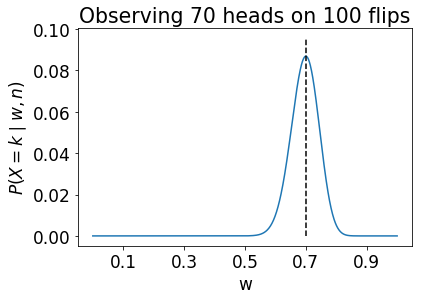

In [12]:
n = 100
k = 70

def plot_binom_like(k,n):
    grid = np.linspace(0,1,1000)
    pmf = binom.pmf(k,n,grid)
    plt.plot(grid, pmf);
    plt.xlabel("w")
    plt.ylabel("$P(X=k \mid w, n)$");
    plt.plot((k/n,k/n),(0,np.max(pmf)*1.1),'--k');
    plt.xticks(np.arange(0.1,1,0.2));
    plt.title("Observing %d heads on %d flips" % (k,n));

plot_binom_like(k,n)

#### Key ideas

- This function tells us the probability of seeing our data given different choices of $w$.
- Maximum likelihood estimation: estimate $w$ by picking the mode (maximum) of this likelihood function.
- In words, I'm going to assume the parameter value(s) that make what I saw most probable. 
  - We're using "what's the probability of seeing what I saw?" as a score for different parameter values.
- However, we're taking this pmf and _thinking of it as a function of $w$ instead of $k$.
  - This is the key insight of MLE!!!
  - Note: this is NOT a probability distribution; it is not normalized (look at the area of the above)
- Note: in this case, although the distribution was discrete, the likelihood function is continuous.
  - That's because the likelihood is a function of the parameter $w$, which in this case is continuous.
  - It's also possible to have discrete parameters.

#### General formula

We want $$\arg \max_w P(X=k \mid w, n)$$

This is $$\arg \max_w {n\choose k} w^k (1-w)^{n-k}$$

We can throw away the parts that don't depend on $w$:

$$\arg \max_w w^k (1-w)^{n-k}$$

Now we can take the derivative w.r.t. $w$ and set to zero (we should also check that it's a maximum; not shown):

$$\frac{dL(w)}{dw}=kw^{k-1}(1-w)^{n-k} - w^k(n-k)(1-w)^{n-k-1}=0$$

After some algebra we get:

$$k(1-w) = (n-k)w$$ or $$w=k/n$$

This result makes sense intuitively: the estimate is the fraction of tosses that landed heads.

But: in general we won't be able to do this in closed form, we'll have to use numerical optimization like gradient descent.

#### Problems with MLE

Here's a situation: you flip the coin once and observe heads. What's the MLE?

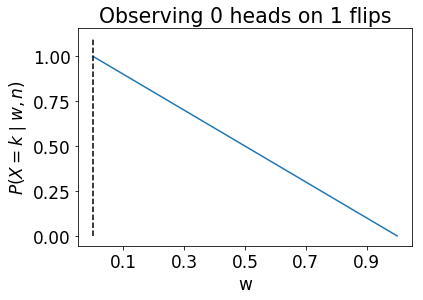

In [13]:
plot_binom_like(0,1)

- If you see 0 heads in 1 flip, then your MLE is $w=0$
- That seems a little intense!
- More on this next class.

### A continuous example

Consider the example of modelling student GPAs. We model this with a Gaussian with unknown mean and $\sigma=1$. You observe $4$. What do you think the mean is?

Let's look at the likelihood of the mean.

- The pdf is $p(y \mid \mu, \sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)$
- The likelihood is this function, viewed as a function of $\mu$ (and we can drop the constants): $L(\mu)=\exp\left(-\frac{(4-\mu)^2}{2}\right)$

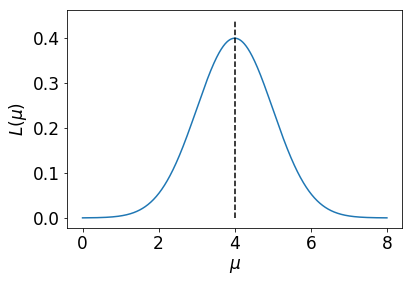

In [14]:
grid = np.linspace(0,8,1000)
lik = norm.pdf(4,loc=grid)
plt.plot(grid,lik);
plt.xlabel('$\mu$');
plt.ylabel('$L(\mu)$');
plt.plot((grid[np.argmax(lik)],grid[np.argmax(lik)]),(0,np.max(lik)*1.1),'--k');

- In this case, the likelihood function is also Gaussian. The maximum likelihood estimate is $4$. Again, an intuitive result.
- We can also account for multiple observations. E.g. if we saw "4" and "3.2", then, assuming iid samples, we multiply the densities:

$$p(y_1,y_2 \mid \mu, \sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_1-\mu)^2}{2\sigma^2}\right) \times \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_2-\mu)^2}{2\sigma^2}\right)$$ if $y_1$ and $y_2$ are independent.

And in general, if we have $n$ iid observations, then the density (and likelihood function) are given by:

$$p(y_1,\ldots,y_n \mid \mu, \sigma)=\prod_{i=1}^n\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_1-\mu)^2}{2\sigma^2}\right) $$

Let's look at this for the observation vector $\begin{bmatrix}4 \\ 3.2 \end{bmatrix}$.

The maximum is at 3.6003600360036003


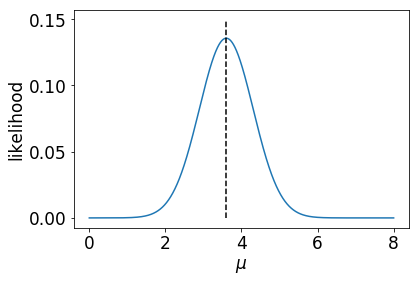

In [15]:
grid = np.linspace(0,8,10000)
lik = norm.pdf(4,loc=grid)*norm.pdf(3.2,loc=grid)
plt.plot(grid,lik);
μ_MLE = grid[np.argmax(lik)]
print("The maximum is at", μ_MLE);
plt.xlabel("$\mu$");
plt.ylabel("likelihood");
plt.plot((μ_MLE, μ_MLE),(0,np.max(lik)*1.1),'--k');

Let's look at this for a larger number of observations. I'll generate data from a Gaussian with a true mean of 3 and a true variance of 1. 

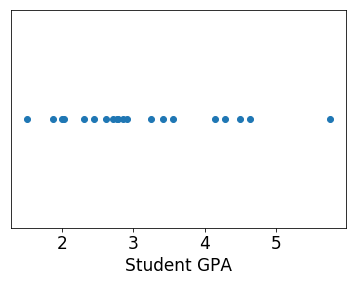

In [16]:
μ = 3
σ = 1
n = 20
data = σ*np.random.randn(n) + μ
plt.scatter(data, 0*data);
plt.yticks(());
plt.xlabel("Student GPA");

The maximum is at 3.1143114311431144


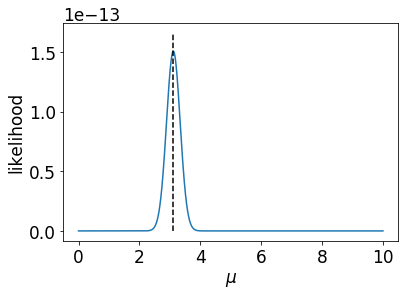

In [17]:
grid = np.linspace(0,10,10000)
lik = np.prod(norm(loc=grid[:,None],scale=σ).pdf(data[None]),axis=1)
plt.plot(grid,lik);
μ_MLE = grid[np.argmax(lik)]
print("The maximum is at", μ_MLE);
plt.xlabel("$\mu$");
plt.ylabel("likelihood");
plt.plot((μ_MLE, μ_MLE),(0,np.max(lik)*1.1),'--k');

Our estimate of the mean is quite close to the true mean, which is reassuring. We can overlay this distribution on the data to see what it looks like:

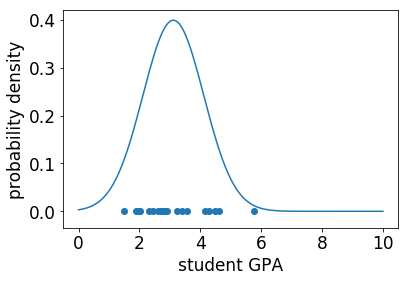

In [18]:
plt.scatter(data,0*data)
plt.plot(grid, norm.pdf(grid, loc=μ_MLE,scale=σ));
plt.xlabel("student GPA");
plt.ylabel("probability density");

Now, what if we don't know $\sigma$ either? Now we have 2 parameters...



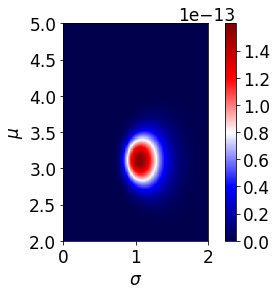

In [20]:
gridσ = np.linspace(0.001,2,200)
gridμ = np.linspace(2,5,200)
meshσ, meshμ = np.meshgrid(gridσ, gridμ)

lik = np.sum(norm(loc=meshμ[:,:,None],scale=meshσ[:,:,None]).logpdf(data[None,None]),axis=-1)

plt.imshow(np.exp(lik),extent=(np.min(gridσ), np.max(gridσ), np.min(gridμ), np.max(gridμ)), origin='lower', cmap=plt.cm.seismic);
plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")
plt.colorbar();

What am I looking at?

- This is still a univariate Gaussian!!!! 
  - Try not to confuse multiple observations from a univariate Gaussian with one observation from a multivariate Gaussian
- So, in this case we have have multiple parameters _and_ multiple observations

### Digression: numerical issues

If you've taken CPSC 302/303 you're heard of floating point errors. Let's say we have 5000 observations:

In [23]:
μ = 3
σ = 1
n = 100
grid = np.linspace(0,10,10000)
data = σ*np.random.randn(n) + μ
lik = np.prod(norm(loc=grid[:,None],scale=σ).pdf(data[None]),axis=1)
lik

array([6.78843676e-250, 9.11226424e-250, 1.22303643e-249, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

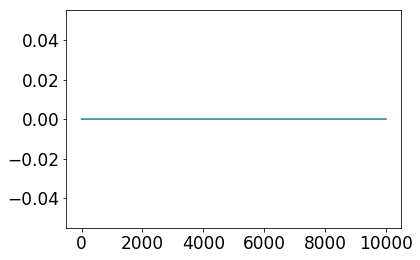

In [22]:
plt.plot(lik);

Hmm...

The problem here is numerical underflow. We can get around this by maximizing the log likelihood instead of the likelihood (same argmax). 

$$p(y \mid w)=\prod_{i=1}^n p(y_i \mid w)$$

So

$$\log p(y \mid w)=\log \prod_{i=1}^n p(y_i \mid w) = \sum_{i=1}^n \log p(y_i \mid w)$$

In [25]:
log_lik = np.sum(norm(loc=grid[:,None],scale=σ).logpdf(data[None]),axis=1)
log_lik

array([ -573.73105256,  -573.43665202,  -573.14235151, ...,
       -2628.10894407, -2628.81444351, -2629.52004296])

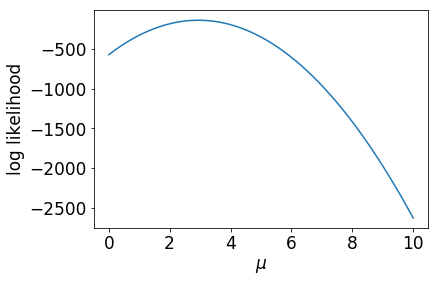

In [28]:
plt.plot(grid,log_lik);
plt.xlabel("$\mu$");
plt.ylabel("log likelihood");